In [110]:
import numpy as np                     # numpy
import pandas as pd                    # pandas
import librosa
import librosa.display
import subprocess

import matplotlib.pyplot as plt
import soundfile as sf

import os

In [111]:
def getFeatureVectorOfAudioFile(filepath) -> np.array([]):
    y, sr = librosa.load(filepath, sr=None)
    
    # Spectral
    rmsStd = np.std(librosa.feature.rms(y=y)) # how much variation in volume/loudness
    spectralContrastMean = np.mean(librosa.feature.spectral_contrast(y=y)) # mean of how much difference is the spectrum (for white noise 0)
    spectralCentroidMean = np.mean(librosa.feature.spectral_centroid(y=y)) # where in the spectrum is the signal the most
    zcrStd = np.std(librosa.feature.zero_crossing_rate(y=y)) # Zero-crossing-rate variation
    zcrMean = np.mean(librosa.feature.zero_crossing_rate(y=y)) # Zero-crossing-rate mean
    
    # Time-based
    tempogramSum = np.sum(librosa.feature.tempogram(y=y)) # intensity and relevance of onsets (like in a beat)
    
    featureVector = [rmsStd, spectralContrastMean, spectralCentroidMean, zcrStd, zcrMean, tempogramSum]
    
    return featureVector
    

In [158]:
def createFeatureMatrixForDirectory(dir: str) -> pd.DataFrame:
    dataFrame = pd.DataFrame(columns=['File', 'RMS Std', 'Spectral Contrast Mean', 'Spectral Centroid Mean', 'ZeroCrossingR Std', 'ZeroCrossingR Mean', 'Tempogram Sum'])
    
    if os.path.isdir(dir):
        for filename in os.listdir(dir):
            filepath = os.path.join(dir, filename)
            name, extension = os.path.splitext(filename)
            if os.path.isfile(filepath) and extension.upper() in ['.WAV']: #just take these extensions
                
                featureVector = getFeatureVectorOfAudioFile(filepath)
                
                newRow = pd.DataFrame.from_records([{
                    'File': name,
                    'RMS Std': featureVector[0],
                    'Spectral Contrast Mean': featureVector[1],
                    'Spectral Centroid Mean': featureVector[2],
                    'ZeroCrossingR Std': featureVector[3],
                    'ZeroCrossingR Mean': featureVector[4],
                    'Tempogram Sum': featureVector[5]
                }])
                dataFrame = pd.concat([dataFrame, newRow])
                
    dataFrame = dataFrame.sort_values(by='File')
    return dataFrame

In [159]:
dataFrame = createFeatureMatrixForDirectory(dir="../videos/processed")

In [160]:
dataFrame

,File,RMS Std,Spectral Contrast Mean,Spectral Centroid Mean,ZeroCrossingR Std,ZeroCrossingR Mean,Tempogram Sum
0,02_HowSheMove_02,0.080128,18.875308,1948.826909,0.054895,0.092221,154561.973703
0,01_PulpFiction_04,0.047167,20.095615,1816.608550,0.035078,0.092653,185171.851674
0,01_PulpFiction_05,0.028004,19.174169,1774.124850,0.061951,0.091759,213211.061136
0,02_HowSheMove_03,0.049920,19.078835,1687.156611,0.038467,0.077914,198668.396928
0,03_ArcticTale_02,0.043664,21.209368,1326.980918,0.052909,0.065794,223684.215891
0,03_ArcticTale_03,0.049232,20.412388,1811.171907,0.052940,0.071703,189680.078656
0,02_HowSheMove_04,0.048772,17.339168,2044.972998,0.053381,0.071234,133592.024926
0,01_PulpFiction_02,0.048424,19.201557,1896.805835,0.059238,0.106563,247691.674776
0,01_PulpFiction_03,0.046020,18.943706,1932.157688,0.055644,0.105732,214849.963044
0,02_HowSheMove_05,0.047260,17.802465,1720.045289,0.062225,0.074777,163364.174520


In [161]:
def featurePerGenre(inputFrame: pd.DataFrame) -> pd.DataFrame:
    #inputFrame.sort_values(by='File')
    
    dataFrame = pd.DataFrame(columns=['Genre', 'RMS Std STD', 'RMS Std MEAN', 'Spectral Contrast Mean STD', 'Spectral Contrast Mean MEAN', 
                                      'Spectral Centroid Mean STD', 'Spectral Centroid Mean MEAN', 'ZeroCrossingR Std STD', 'ZeroCrossingR Std MEAN', 
                                      'ZeroCrossingR Mean STD', 'ZeroCrossingR Mean MEAN', 'Tempogram Sum STD', 'Tempogram Sum MEAN'])
    
    thrillerFrame = inputFrame[inputFrame['File'].str.startswith('01_')]
    danceFrame = inputFrame[inputFrame['File'].str.startswith('02_')]
    documentaryFrame = inputFrame[inputFrame['File'].str.startswith('03_')]
    
    newRow = pd.DataFrame.from_records([{
        'Genre': 'Thriller', 
        'RMS Std STD': np.std(thrillerFrame['RMS Std']), 
        'RMS Std MEAN': np.mean(thrillerFrame['RMS Std']), 
        'Spectral Contrast Mean STD': np.std(thrillerFrame['Spectral Contrast Mean']), 
        'Spectral Contrast Mean MEAN': np.mean(thrillerFrame['Spectral Contrast Mean']), 
        'Spectral Centroid Mean STD': np.std(thrillerFrame['Spectral Centroid Mean']), 
        'Spectral Centroid Mean MEAN': np.mean(thrillerFrame['Spectral Centroid Mean']), 
        'ZeroCrossingR Std STD': np.std(thrillerFrame['ZeroCrossingR Std']), 
        'ZeroCrossingR Std MEAN': np.mean(thrillerFrame['ZeroCrossingR Std']), 
        'ZeroCrossingR Mean STD': np.std(thrillerFrame['ZeroCrossingR Mean']), 
        'ZeroCrossingR Mean MEAN': np.mean(thrillerFrame['ZeroCrossingR Mean']), 
        'Tempogram Sum STD': np.std(thrillerFrame['Tempogram Sum']), 
        'Tempogram Sum MEAN': np.mean(thrillerFrame['Tempogram Sum'])
    }])
    dataFrame = pd.concat([dataFrame, newRow])
    
    newRow = pd.DataFrame.from_records([{
        'Genre': 'Dance', 
        'RMS Std STD': np.std(danceFrame['RMS Std']), 
        'RMS Std MEAN': np.mean(danceFrame['RMS Std']), 
        'Spectral Contrast Mean STD': np.std(danceFrame['Spectral Contrast Mean']), 
        'Spectral Contrast Mean MEAN': np.mean(danceFrame['Spectral Contrast Mean']), 
        'Spectral Centroid Mean STD': np.std(danceFrame['Spectral Centroid Mean']), 
        'Spectral Centroid Mean MEAN': np.mean(danceFrame['Spectral Centroid Mean']), 
        'ZeroCrossingR Std STD': np.std(danceFrame['ZeroCrossingR Std']), 
        'ZeroCrossingR Std MEAN': np.mean(danceFrame['ZeroCrossingR Std']), 
        'ZeroCrossingR Mean STD': np.std(danceFrame['ZeroCrossingR Mean']), 
        'ZeroCrossingR Mean MEAN': np.mean(danceFrame['ZeroCrossingR Mean']), 
        'Tempogram Sum STD': np.std(danceFrame['Tempogram Sum']), 
        'Tempogram Sum MEAN': np.mean(danceFrame['Tempogram Sum'])
    }])
    dataFrame = pd.concat([dataFrame, newRow])
    
    newRow = pd.DataFrame.from_records([{
        'Genre': 'Documentary', 
        'RMS Std STD': np.std(documentaryFrame['RMS Std']), 
        'RMS Std MEAN': np.mean(documentaryFrame['RMS Std']), 
        'Spectral Contrast Mean STD': np.std(documentaryFrame['Spectral Contrast Mean']), 
        'Spectral Contrast Mean MEAN': np.mean(documentaryFrame['Spectral Contrast Mean']), 
        'Spectral Centroid Mean STD': np.std(documentaryFrame['Spectral Centroid Mean']), 
        'Spectral Centroid Mean MEAN': np.mean(documentaryFrame['Spectral Centroid Mean']), 
        'ZeroCrossingR Std STD': np.std(documentaryFrame['ZeroCrossingR Std']), 
        'ZeroCrossingR Std MEAN': np.mean(documentaryFrame['ZeroCrossingR Std']), 
        'ZeroCrossingR Mean STD': np.std(documentaryFrame['ZeroCrossingR Mean']), 
        'ZeroCrossingR Mean MEAN': np.mean(documentaryFrame['ZeroCrossingR Mean']), 
        'Tempogram Sum STD': np.std(documentaryFrame['Tempogram Sum']), 
        'Tempogram Sum MEAN': np.mean(documentaryFrame['Tempogram Sum'])
    }])
    dataFrame = pd.concat([dataFrame, newRow])
    
    
    return dataFrame, thrillerFrame, danceFrame, documentaryFrame
    

In [162]:
def processAndDisplayAudioDirectoryFeatures(dir: str, plot: bool = True, showDataframes: bool = True):
    featureMatrix = createFeatureMatrixForDirectory(dir)
    display(featureMatrix)
    
    genreFrame, thrillerFrame, danceFrame, documentaryFrame = featurePerGenre(featureMatrix)
    display(genreFrame)

    plt.title('Variation in volume (dynamics)')
    plt.plot(np.arange(0, len(thrillerFrame)), thrillerFrame['RMS Std'], label='Thriller')
    plt.plot(np.arange(0, len(danceFrame)), danceFrame['RMS Std'], label='Dance')
    plt.plot(np.arange(0, len(documentaryFrame)), documentaryFrame['RMS Std'], label='Documentary')
    plt.xlabel('Files')
    plt.ylabel('RMS Std')
    plt.legend(loc ="upper right")
    plt.show()

    plt.title('Variation in the frequency spectrum')
    plt.plot(np.arange(0, len(thrillerFrame)), thrillerFrame['Spectral Contrast Mean'], label='Thriller')
    plt.plot(np.arange(0, len(danceFrame)), danceFrame['Spectral Contrast Mean'], label='Dance')
    plt.plot(np.arange(0, len(documentaryFrame)), documentaryFrame['Spectral Contrast Mean'], label='Documentary')
    plt.xlabel('Files')
    plt.ylabel('Spectral Contrast Mean')
    plt.legend(loc ="upper right")
    plt.show()

    plt.title('Most prominent frequency')
    plt.plot(np.arange(0, len(thrillerFrame)), thrillerFrame['Spectral Centroid Mean'], label='Thriller')
    plt.plot(np.arange(0, len(danceFrame)), danceFrame['Spectral Centroid Mean'], label='Dance')
    plt.plot(np.arange(0, len(documentaryFrame)), documentaryFrame['Spectral Centroid Mean'], label='Documentary')
    plt.xlabel('Files')
    plt.ylabel('Spectral Centroid Mean')
    plt.legend(loc ="upper right")
    plt.show()

    plt.title('Variation of Zero-Crossing-Rate')
    plt.plot(np.arange(0, len(thrillerFrame)), thrillerFrame['ZeroCrossingR Std'], label='Thriller')
    plt.plot(np.arange(0, len(danceFrame)), danceFrame['ZeroCrossingR Std'], label='Dance')
    plt.plot(np.arange(0, len(documentaryFrame)), documentaryFrame['ZeroCrossingR Std'], label='Documentary')
    plt.xlabel('Files')
    plt.ylabel('ZeroCrossingR Std')
    plt.legend(loc ="upper right")
    plt.show()

    plt.title('Mean of Zero-Crossing-Rate')
    plt.plot(np.arange(0, len(thrillerFrame)), thrillerFrame['ZeroCrossingR Mean'], label='Thriller')
    plt.plot(np.arange(0, len(danceFrame)), danceFrame['ZeroCrossingR Mean'], label='Dance')
    plt.plot(np.arange(0, len(documentaryFrame)), documentaryFrame['ZeroCrossingR Mean'], label='Documentary')
    plt.xlabel('Files')
    plt.ylabel('ZeroCrossingR Mean')
    plt.legend(loc ="upper right")
    plt.show()

    plt.title('Amount and Intensity of Onsets')
    plt.plot(np.arange(0, len(thrillerFrame)), thrillerFrame['Tempogram Sum'], label='Thriller')
    plt.plot(np.arange(0, len(danceFrame)), danceFrame['Tempogram Sum'], label='Dance')
    plt.plot(np.arange(0, len(documentaryFrame)), documentaryFrame['Tempogram Sum'], label='Documentary')
    plt.xlabel('Files')
    plt.ylabel('Tempogram Sum')
    plt.legend(loc ="upper right")
    plt.show()
    
    

,File,RMS Std,Spectral Contrast Mean,Spectral Centroid Mean,ZeroCrossingR Std,ZeroCrossingR Mean,Tempogram Sum
0,02_HowSheMove_02,0.080128,18.875308,1948.826909,0.054895,0.092221,154561.973703
0,01_PulpFiction_04,0.047167,20.095615,1816.608550,0.035078,0.092653,185171.851674
0,01_PulpFiction_05,0.028004,19.174169,1774.124850,0.061951,0.091759,213211.061136
0,02_HowSheMove_03,0.049920,19.078835,1687.156611,0.038467,0.077914,198668.396928
0,03_ArcticTale_02,0.043664,21.209368,1326.980918,0.052909,0.065794,223684.215891
0,03_ArcticTale_03,0.049232,20.412388,1811.171907,0.052940,0.071703,189680.078656
0,02_HowSheMove_04,0.048772,17.339168,2044.972998,0.053381,0.071234,133592.024926
0,01_PulpFiction_02,0.048424,19.201557,1896.805835,0.059238,0.106563,247691.674776
0,01_PulpFiction_03,0.046020,18.943706,1932.157688,0.055644,0.105732,214849.963044
0,02_HowSheMove_05,0.047260,17.802465,1720.045289,0.062225,0.074777,163364.174520


,Genre,RMS Std STD,RMS Std MEAN,Spectral Contrast Mean STD,Spectral Contrast Mean MEAN,Spectral Centroid Mean STD,Spectral Centroid Mean MEAN,ZeroCrossingR Std STD,ZeroCrossingR Std MEAN,ZeroCrossingR Mean STD,ZeroCrossingR Mean MEAN,Tempogram Sum STD,Tempogram Sum MEAN
0,Thriller,0.012566,0.047719,0.478427,19.320713,350.005226,1813.607145,0.016762,0.058433,0.023366,0.093348,28041.083122,199791.758177
0,Dance,0.012732,0.050022,0.955004,18.958432,347.876998,1978.333764,0.011000,0.056538,0.027474,0.094981,30802.873712,180175.242433
0,Documentary,0.005988,0.047252,0.647266,20.241246,267.483998,1749.409716,0.003646,0.053219,0.016116,0.083832,33616.625576,237882.778417


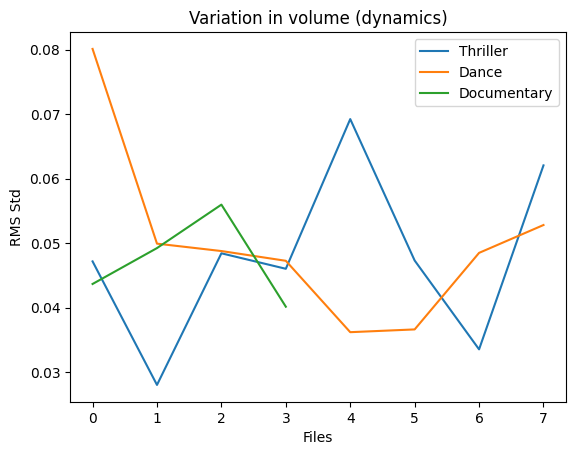

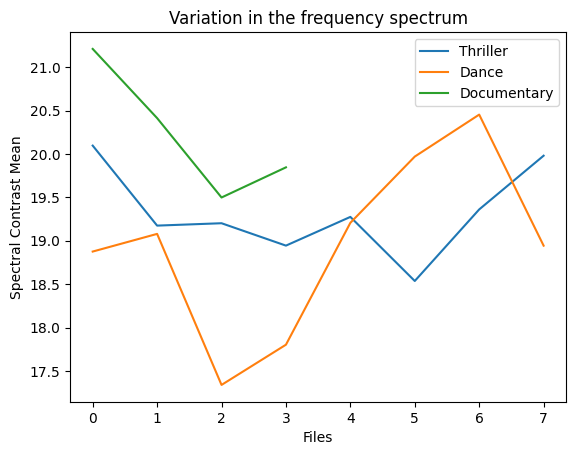

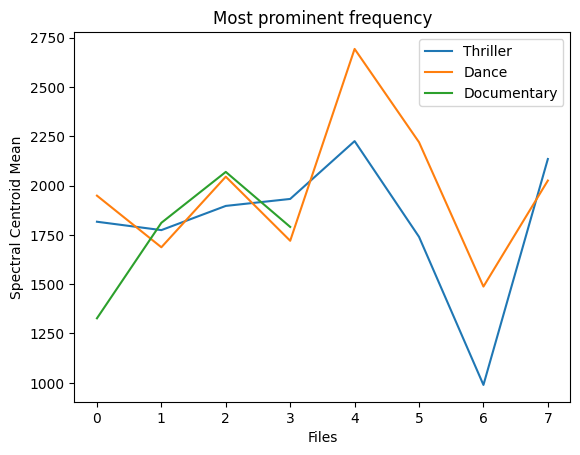

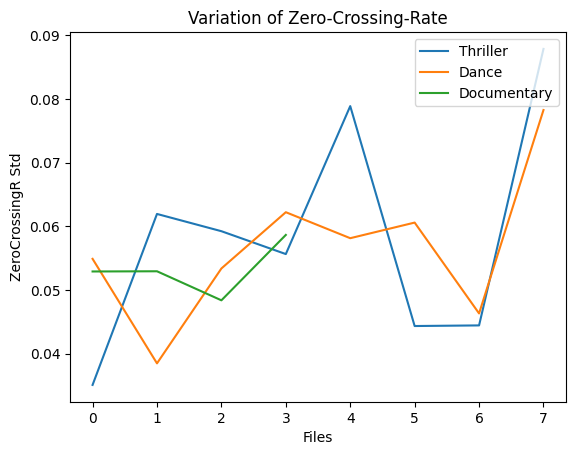

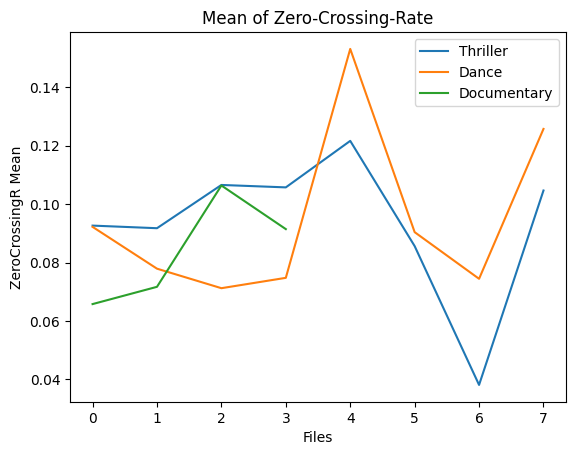

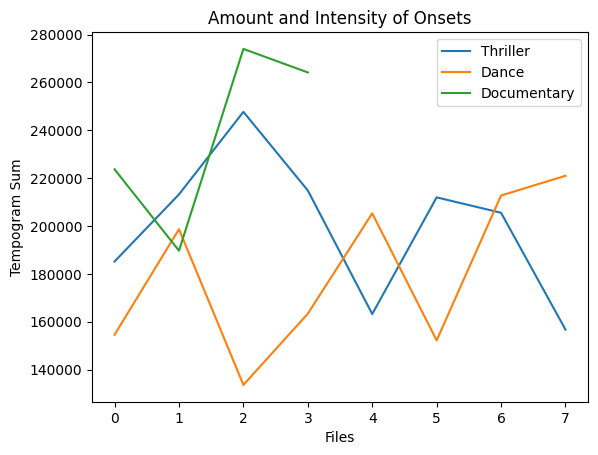

In [163]:
#processAndDisplayAudioDirectoryFeatures(dir="../videos/processed")